In [127]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [129]:
data = pd.read_csv('macro_data_1981.csv')

### Exploratory Data Analysis

In [130]:
# Display basic info
print("Data Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16274 entries, 0 to 16273
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                16274 non-null  object 
 1   10Y_Treasury_Yield  16274 non-null  float64
 2   CPI                 16274 non-null  float64
 3   Fed_Funds_Rate      16274 non-null  float64
 4   GDP                 16274 non-null  float64
 5   Inflation_Sticky    16274 non-null  float64
 6   M2_Money_Supply     16274 non-null  float64
 7   Unemployment Rate   16274 non-null  float64
 8   Inflation           16274 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.1+ MB
None

Summary Statistics:
       10Y_Treasury_Yield           CPI  Fed_Funds_Rate           GDP  \
count        16274.000000  16274.000000    16274.000000  16274.000000   
mean             5.512998    188.302487        4.222350  12695.274051   
std              3.222125     60.962122      

In [131]:
data.head()

,Date,10Y_Treasury_Yield,CPI,Fed_Funds_Rate,GDP,Inflation_Sticky,M2_Money_Supply,Unemployment Rate,Inflation
0,1981-01-01,12.43,87.2,19.08,3124.206,12.018101,1601.8,7.5,12.35
1,1981-01-02,12.42,87.2,19.08,3124.206,12.018101,1601.8,7.5,12.35
2,1981-01-03,12.42,87.2,19.08,3124.206,12.018101,1601.8,7.5,12.35
3,1981-01-04,12.42,87.2,19.08,3124.206,12.018101,1601.8,7.5,12.35
4,1981-01-05,12.15,87.2,19.08,3124.206,12.018101,1620.7,7.5,12.35


In [132]:
data['Fed_Funds_Factor'] = (data['Fed_Funds_Rate'] / 100) + 1

In [133]:
# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

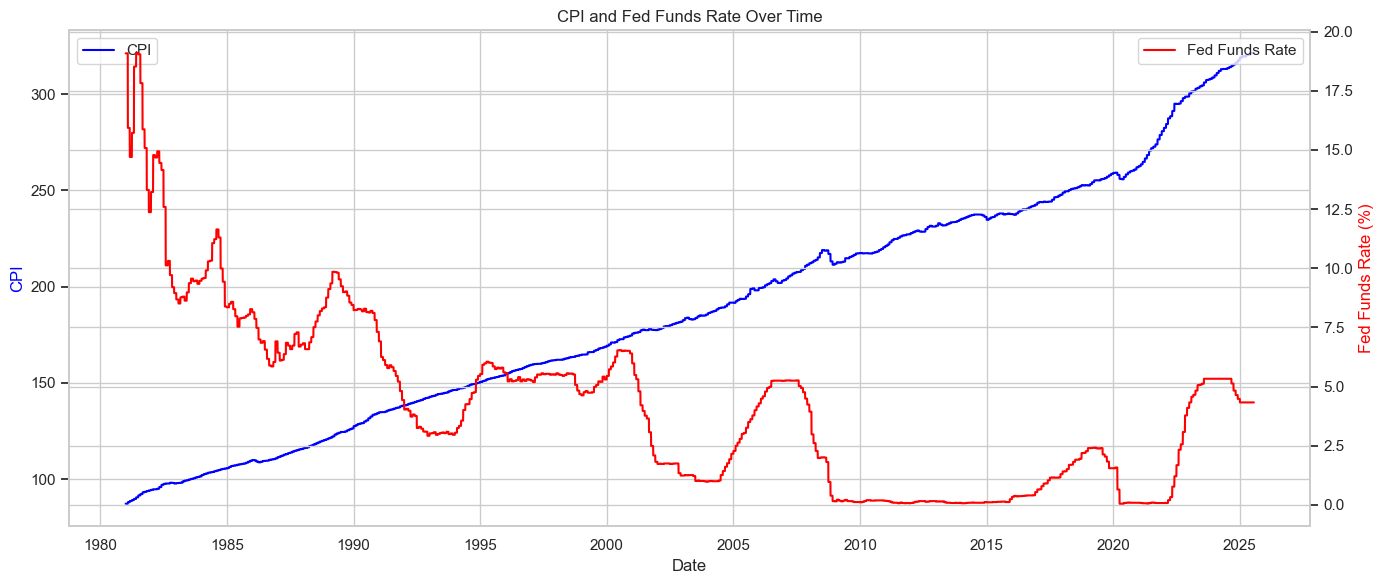

In [134]:
# Set Date as index for resampling
data.set_index('Date', inplace=True)

# Create the plot
plt.figure(figsize=(14, 6))

# Plot CPI
ax1 = sns.lineplot(x=data.index, y=data['CPI'], color='blue', label='CPI')
ax1.set_ylabel('CPI', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=data.index, y=data['Fed_Funds_Rate'], color='red', ax=ax2, label='Fed Funds Rate')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('CPI and Fed Funds Rate Over Time')
plt.tight_layout()
plt.show()

In [135]:
# Assuming 'data' is already indexed by datetime and resampled monthly:
monthly_data = data.resample('M').mean()

# Create new column: CPI Rate of Change (%)
monthly_data['CPI_Rate_Change'] = monthly_data['CPI'].pct_change() * 100

C:\Users\steve\AppData\Local\Temp\ipykernel_5652\3910782868.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()


C:\Users\steve\AppData\Local\Temp\ipykernel_5652\2016439849.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()


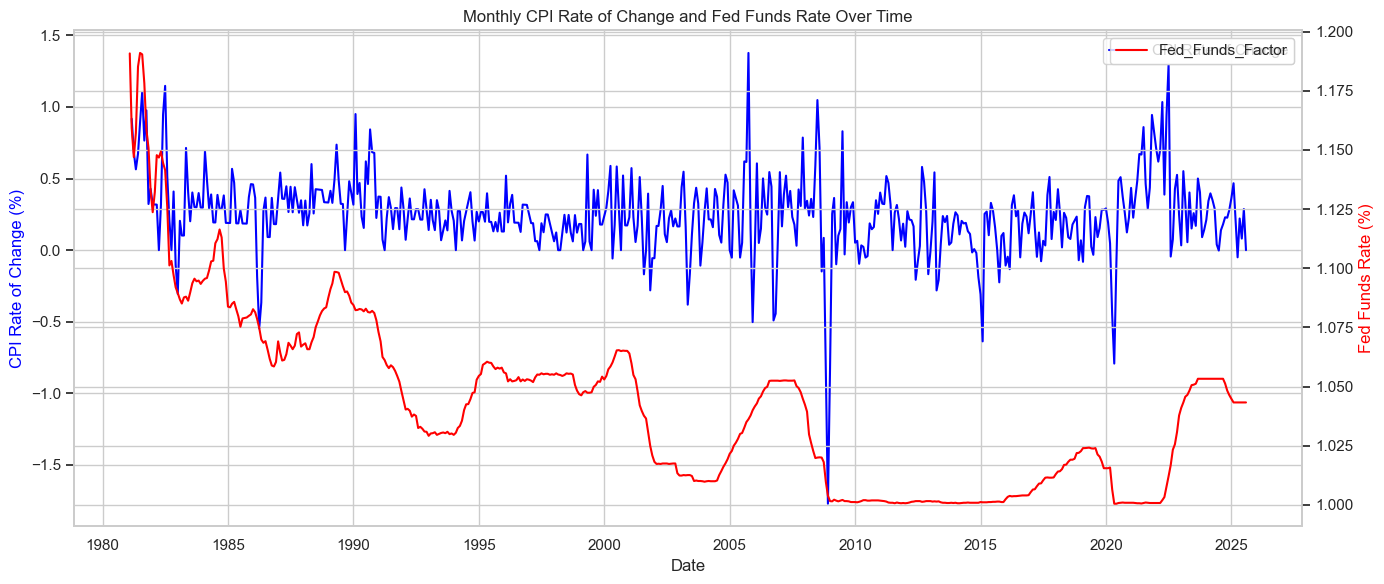

In [136]:
# Resample to monthly average
monthly_data = data.resample('M').mean()

# Calculate month-to-month CPI rate of change (%)
monthly_data['CPI_Rate_Change'] = monthly_data['CPI'].pct_change() * 100

# Create the plot
plt.figure(figsize=(14, 6))

# Plot CPI Rate of Change
ax1 = sns.lineplot(x=monthly_data.index, y=monthly_data['CPI_Rate_Change'], color='blue', label='CPI Rate of Change')
ax1.set_ylabel('CPI Rate of Change (%)', color='blue')
ax1.set_xlabel('Date')

# Plot Fed Funds Rate on secondary Y-axis
ax2 = ax1.twinx()
sns.lineplot(x=monthly_data.index, y=monthly_data['Fed_Funds_Factor'], color='red', ax=ax2, label='Fed_Funds_Factor')
ax2.set_ylabel('Fed Funds Rate (%)', color='red')

# Title and layout
plt.title('Monthly CPI Rate of Change and Fed Funds Rate Over Time')
plt.tight_layout()
plt.show()

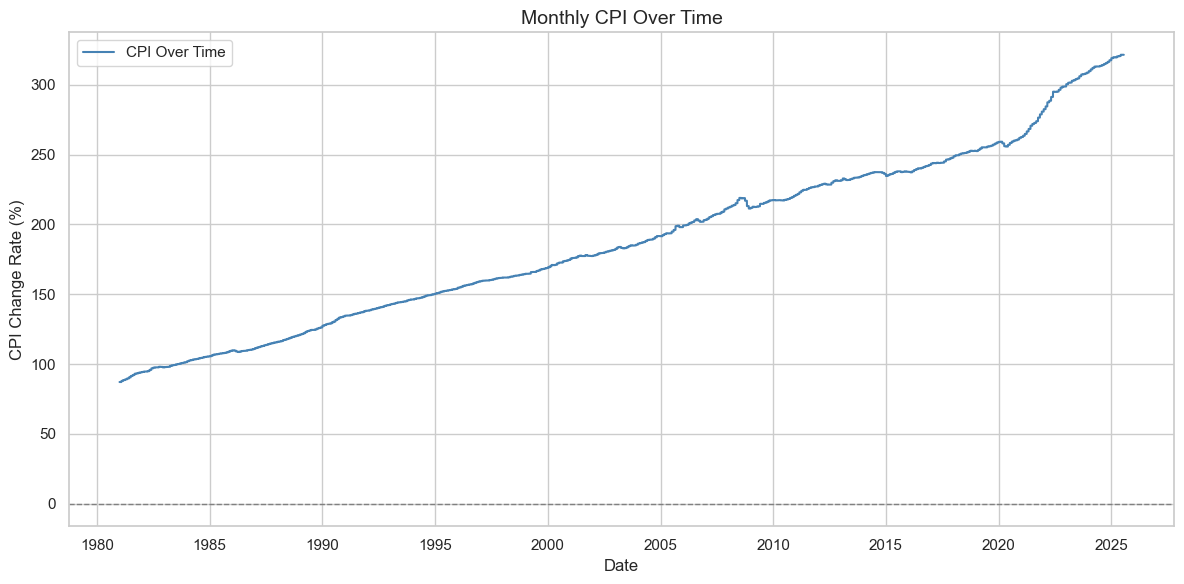

In [137]:
# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot CPI monthly rate of change
plt.plot(data.index, data['CPI'], label='CPI Over Time', color='steelblue')

# Title and labels
plt.title("Monthly CPI Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("CPI Change Rate (%)", fontsize=12)

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


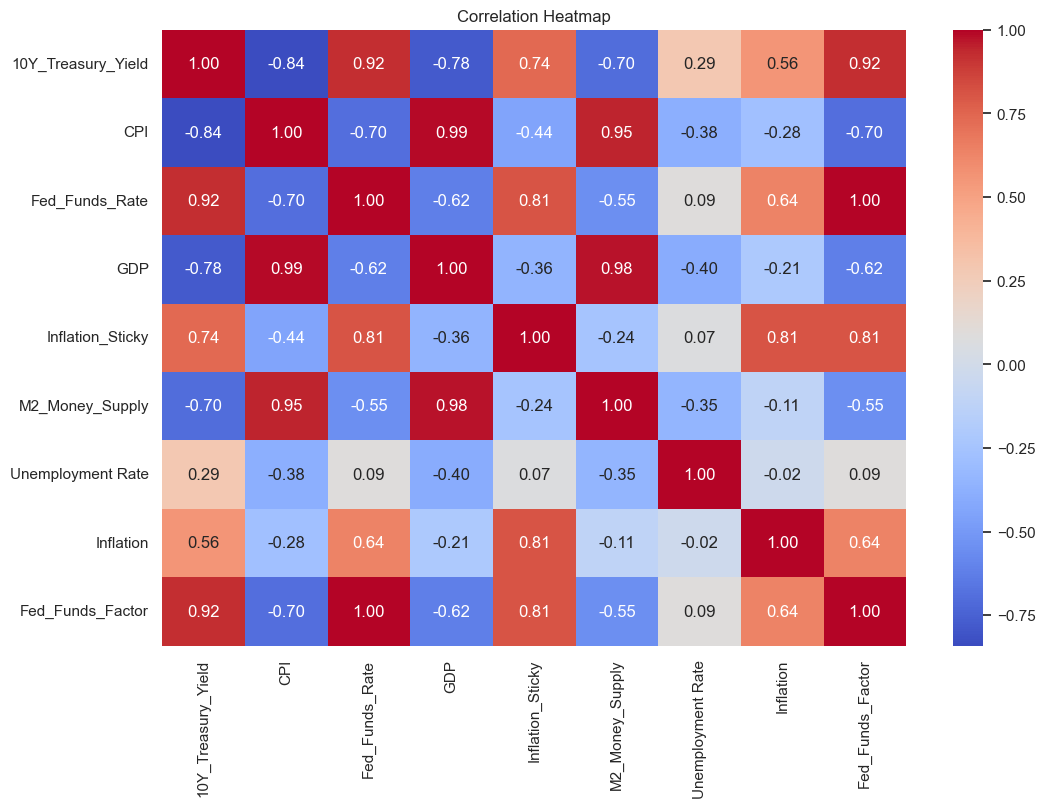

In [138]:
# Correlation heatmap (for numeric columns)
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### Random Forest

In [152]:
# 1. Ensure datetime index
if not isinstance(data.index, pd.DatetimeIndex):
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.set_index('Date')
    else:
        raise ValueError("No 'Date' column found, and index is not datetime.")

# 2. Create lag features
data['M2_lag1'] = data['M2_Money_Supply'].shift(1)
data['FedFundsFactor_lag1'] = data['Fed_Funds_Factor'].shift(1)
data['CPI_lag1'] = data['CPI'].shift(1)
data['CPI_lag3'] = data['CPI'].shift(3)
data['CPI_lag6'] = data['CPI'].shift(6)

# 3. Create 1-month ahead target
data['CPI_1mo_ahead'] = data['CPI'].shift(-30)  # assumes daily data

# 4. Define features
features = [
    'Fed_Funds_Factor',
    'FedFundsFactor_lag1',
    'M2_Money_Supply',
    'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag1',
    'CPI_lag3',
    'CPI_lag6'
]

In [153]:
# 5. Train Random Forest model on 1-month-ahead CPI
def train_forecast_model(horizon_label):
    print(f"\n🔮 Forecasting CPI {horizon_label}")

    target = f'CPI_{horizon_label}'
    df_model = data[features + [target]].dropna()

    X = df_model[features]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error:", round(mse, 2))
    print("R² Score:", round(r2, 4))

    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual CPI")
    plt.ylabel("Predicted CPI")
    plt.title(f"Random Forest: Actual vs Predicted CPI ({horizon_label})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


🔮 Forecasting CPI 1mo_ahead
Mean Squared Error: 0.01
R² Score: 1.0


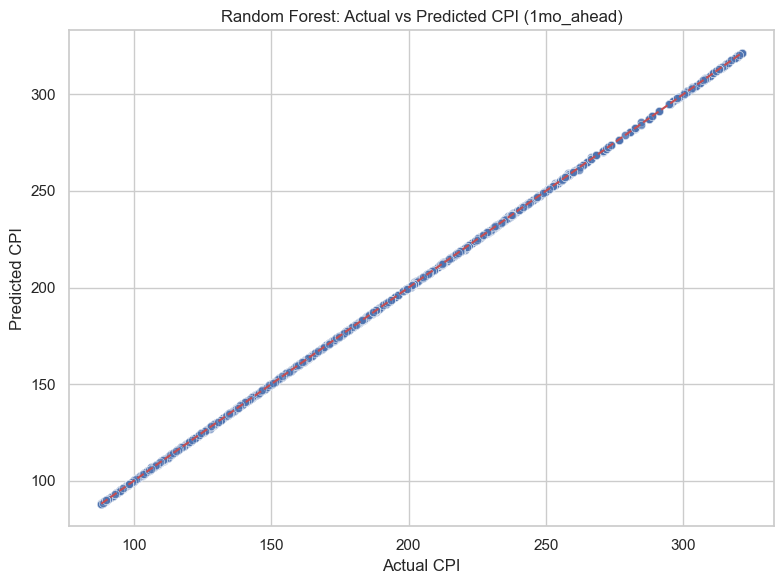

C:\Users\steve\AppData\Local\Temp\ipykernel_5652\2880222999.py:15: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_5652\2880222999.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  past_cpi = data['CPI'].dropna().last('12M')


In [161]:
# Train 1-month-ahead model
model_rf_1mo = train_forecast_model("1mo_ahead")

# 6. Setup for recursive forecast
latest = data.dropna().iloc[-1]
last_date = data.index.max()

fed_rate = 4.33
fed_factor = (fed_rate / 100) + 1
m2 = latest['M2_Money_Supply']
m2_lag1 = m2
treasury_yield = latest['10Y_Treasury_Yield']

# Start CPI lags from last known values
past_cpi = data['CPI'].dropna().last('12M')
cpi_lag1 = past_cpi.iloc[-1]
cpi_lag3 = past_cpi.iloc[-3]
cpi_lag6 = past_cpi.iloc[-6]

forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_cpi = []

for _ in range(12):
    input_df = pd.DataFrame([{
        'Fed_Funds_Factor': fed_factor,
        'FedFundsFactor_lag1': fed_factor,
        'M2_Money_Supply': m2,
        'M2_lag1': m2_lag1,
        '10Y_Treasury_Yield': treasury_yield,
        'CPI_lag1': cpi_lag1,
        'CPI_lag3': cpi_lag3,
        'CPI_lag6': cpi_lag6
    }])

    pred_cpi = model_rf_1mo.predict(input_df)[0]
    forecast_cpi.append(pred_cpi)

    # Update CPI lags
    cpi_lag6, cpi_lag3, cpi_lag1 = cpi_lag3, cpi_lag1, pred_cpi

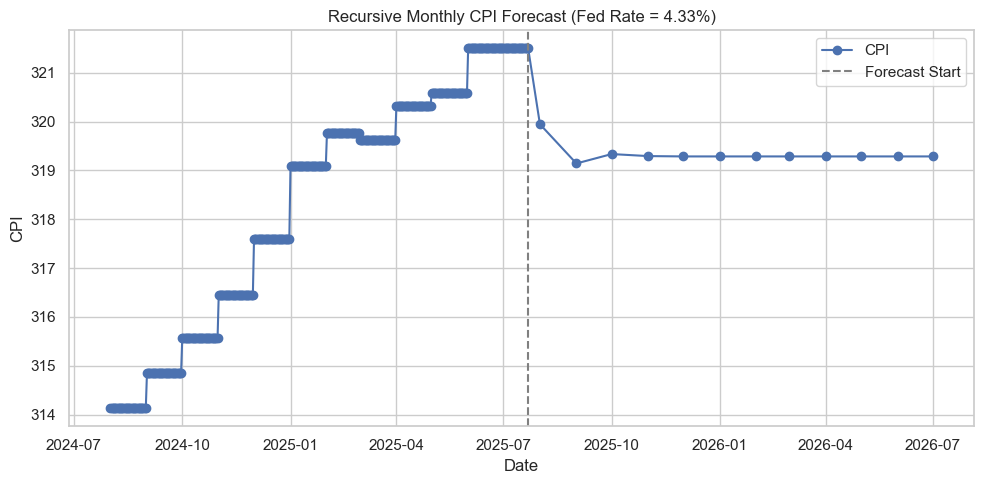

In [162]:
# 7. Combine for plotting
combined_dates = past_cpi.index.append(forecast_dates)
combined_cpi = past_cpi.tolist() + forecast_cpi

plt.figure(figsize=(10, 5))
plt.plot(combined_dates, combined_cpi, marker='o', label='CPI')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title(f"Recursive Monthly CPI Forecast (Fed Rate = {fed_rate}%)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Linear Regression

In [144]:
# 1. Create 1-month-ahead CPI target
data['CPI_1mo_ahead'] = data['CPI'].shift(-30)
data['CPI_lag1'] = data['CPI'].shift(1)

# 2. Features (same as before)
features_1mo = [
    'Fed_Funds_Factor',
    'FedFundsFactor_lag1',
    'M2_Money_Supply',
    'M2_lag1',
    '10Y_Treasury_Yield',
    'CPI_lag1'
]

# 3. Prepare dataset and train Linear Regression
df_model = data[features_1mo + ['CPI_1mo_ahead']].dropna()
X = df_model[features_1mo]
y = df_model['CPI_1mo_ahead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_1mo = LinearRegression()
model_1mo.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


📉 Linear Regression (1-Month CPI Forecast)
Mean Squared Error: 0.321
R² Score: 0.9999

Feature Coefficients:
Fed_Funds_Factor: 17.694200
FedFundsFactor_lag1: -15.150946
M2_Money_Supply: -0.000454
M2_lag1: 0.000544
10Y_Treasury_Yield: -0.038514
CPI_lag1: 0.992953


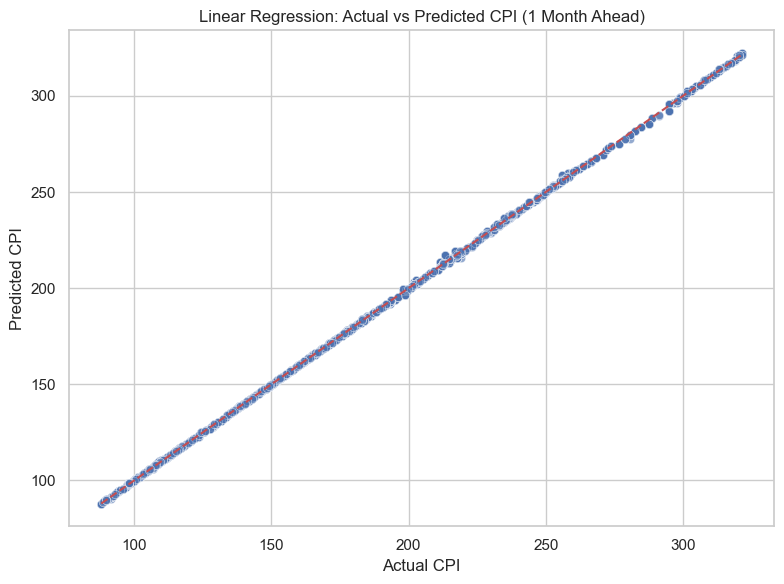

In [145]:
# 8. Evaluate model
y_pred = model_1mo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 9. Output results
print("📉 Linear Regression (1-Month CPI Forecast)")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.4f}")
print("\nFeature Coefficients:")
for name, coef in zip(features_1mo, model_1mo.coef_):
    print(f"{name}: {coef:.6f}")

# 10. Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CPI")
plt.ylabel("Predicted CPI")
plt.title("Linear Regression: Actual vs Predicted CPI (1 Month Ahead)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_5652\2048911781.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_5652\2048911781.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  past_cpi = data['CPI'].dropna().last('12M')
C:\Users\steve\AppData\Local\Temp\ipykernel_5652\2048911781.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_cpi = past_cpi[-1]


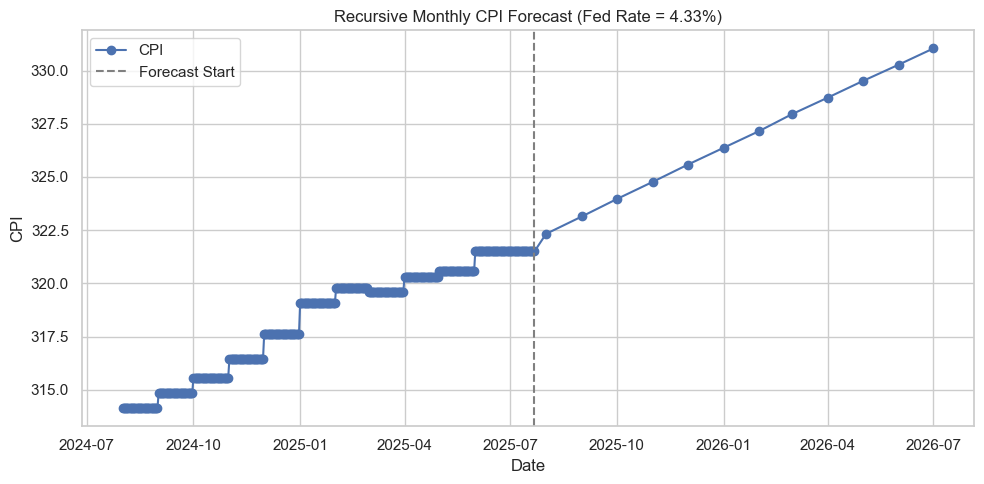

In [146]:
# 4. Begin recursive forecast from latest values
last_date = data.index.max()
past_cpi = data['CPI'].dropna().last('12M')
initial_cpi = past_cpi[-1]

fed_rate = 4.33  # Example Current Fed Rate, can be adjusted
fed_factor = (fed_rate / 100) + 1
m2 = data['M2_Money_Supply'].iloc[-1]
m2_lag1 = m2
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# 5. Forecast next 12 months recursively
forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_cpi = []

current_cpi = initial_cpi  # start from last actual CPI
# Start from the last actual CPI value as the lag
cpi_lag1 = initial_cpi

for _ in range(12):
    input_df = pd.DataFrame([{
        'Fed_Funds_Factor': fed_factor,
        'FedFundsFactor_lag1': fed_factor,
        'M2_Money_Supply': m2,
        'M2_lag1': m2_lag1,
        '10Y_Treasury_Yield': treasury_yield,
        'CPI_lag1': cpi_lag1  # <--- add this!
    }])

    pred_cpi = model_1mo.predict(input_df)[0]
    forecast_cpi.append(pred_cpi)

    # Update lags
    m2_lag1 = m2  # (still static unless you simulate M2)
    cpi_lag1 = pred_cpi  # <--- update CPI lag for next iteration

# 6. Combine and plot
combined_dates = past_cpi.index.append(forecast_dates)
combined_cpi = past_cpi.tolist() + forecast_cpi

plt.figure(figsize=(10, 5))
plt.plot(combined_dates, combined_cpi, marker='o', label='CPI')
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("Recursive Monthly CPI Forecast (Fed Rate = 4.33%)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_5652\479086027.py:4: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  initial_cpi = data['CPI'].dropna().last('12M')[-1]
C:\Users\steve\AppData\Local\Temp\ipykernel_5652\479086027.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  initial_cpi = data['CPI'].dropna().last('12M')[-1]
C:\Users\steve\AppData\Local\Temp\ipykernel_5652\479086027.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_cpi = data['CPI'].dropna().last('12M')[-1]


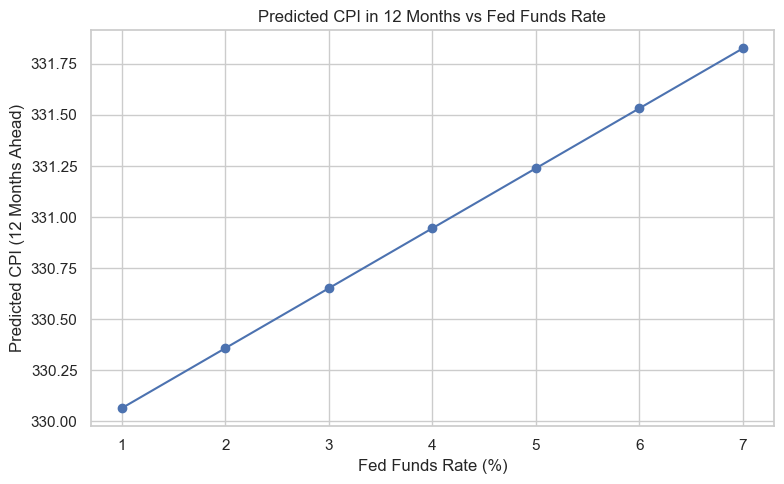

In [147]:
# Forecast setup
rates = np.arange(1, 8, 1)  # Fed rates from 1% to 7%
forecast_horizon = 12       # months
initial_cpi = data['CPI'].dropna().last('12M')[-1]
m2 = data['M2_Money_Supply'].iloc[-1]
treasury_yield = data['10Y_Treasury_Yield'].iloc[-1]

# Store final CPI for each rate
predicted_cpi_12mo = []

# Loop over rates and forecast CPI path
for rate in rates:
    fed_factor = (rate / 100) + 1
    m2_lag1 = m2
    cpi_lag1 = initial_cpi
    forecast_cpi = []

    for _ in range(forecast_horizon):
        input_df = pd.DataFrame([{
            'Fed_Funds_Factor': fed_factor,
            'FedFundsFactor_lag1': fed_factor,
            'M2_Money_Supply': m2,
            'M2_lag1': m2_lag1,
            '10Y_Treasury_Yield': treasury_yield,
            'CPI_lag1': cpi_lag1
        }])

        pred_cpi = model_1mo.predict(input_df)[0]
        forecast_cpi.append(pred_cpi)
        cpi_lag1 = pred_cpi
        m2_lag1 = m2

    # Record final CPI after 12 months
    predicted_cpi_12mo.append(forecast_cpi[-1])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(rates, predicted_cpi_12mo, marker='o', linestyle='-')
plt.title("Predicted CPI in 12 Months vs Fed Funds Rate")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Predicted CPI (12 Months Ahead)")
plt.grid(True)
plt.tight_layout()
plt.show()